In [1]:
from dataclasses import dataclass
import itertools
import logging
import random
import math
import numpy as np
import json
import pickle
import time
import torch
import sys
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
from probe_utils import *

from omegaconf import OmegaConf
from pathlib import Path
from torch import nn, Tensor
from torch.nn import functional as F
from typing import List, Optional, Tuple
import os
# os.chdir("/data/tianyu_guo/birth")
from data import DataArgs, Dataset, iterate_batches, make_dataset
from ihead_full_model import ModelArgs, Transformer, forward_hook, test_value, test_sink

%load_ext autoreload
%autoreload 2


In [2]:
fn = "/data/tianyu_guo/birth/figures"

In [3]:
run_path_server = "/data/tianyu_guo/birth/gens/pre_final/dormant_copy"
# run_path_server2="/data/tianyu_guo/birth/gens/special/dormant_copy_2"
model, cfg, x, y, ds = load_model(run_path_local="/Users/guotianyu/GitHub/birth/gens/special/markov", run_path_server=run_path_server, n_layers=1, n_heads=1, bos_num=1, train_steps=9980, delim=0, with_data=True, data_path_local="/Users/guotianyu/GitHub/birth/data", data_path_server="/data/tianyu_guo/birth/data")
hook = forward_hook(target_layers=[], target_name="")
predicts, outputs_list = model.modified_forward_with_hook(x, hook)
model.cuda()
trigger_toks, attns_to_0, markov_tok = get_triggers(ds, model, hook, cutoff=0.89)

In [4]:
active_seq = np.array([65, 35, 39, 57, 59,  1, 59, 57,  1, 57, 58, 57, 57,  1, 57, 39, 58, 39, 60, 43, 60, 43, 60, 39, 52,  1, 52, 45, 59, 57,  1, 57])
dormant_seq = np.array([65, 21, 26, 15, 17, 31, 47, 52, 47, 52, 45, 50, 63,  0, 21, 26, 53, 56, 61, 39, 61, 46, 47, 50, 53, 60, 63, 53, 39, 57, 46, 39])
seqs = np.stack((dormant_seq, active_seq), axis=0)
predicts_plot, outputs_list_plot = model.modified_forward_with_hook(torch.from_numpy(seqs).cuda(), hook)
outputs_list_plot = move_device(outputs_list_plot)

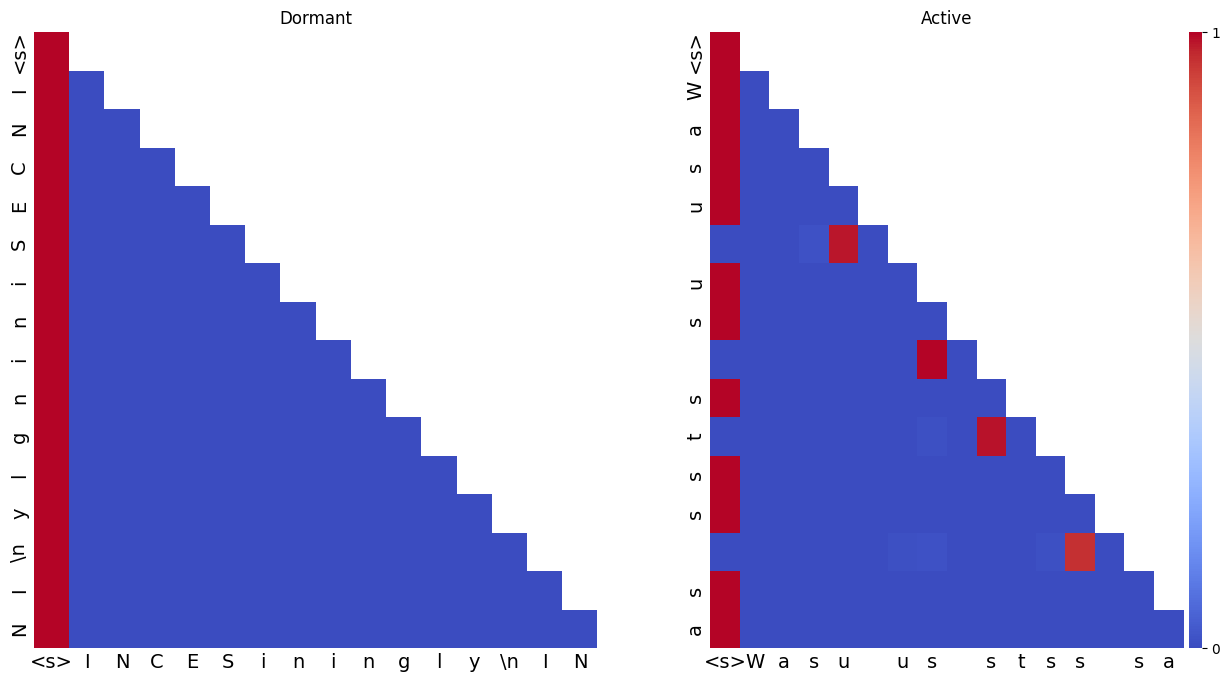

In [5]:
seq_len = 16
seq_idx = 0
layer_idx = 0
head_idx = 0
titles = ['Dormant', 'Active']
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes = axes.flatten()
attns = outputs_list_plot[0]['attn_weights'].detach().numpy()
for seq_idx in range(2):
    ax = axes[seq_idx]
    sub_seq = seqs[seq_idx, :seq_len]
    text = ds.decode(sub_seq)
    text[0] = r'<s>'
    if seq_idx == 0:
        text[-3] = r"\n"
    label_text_x = text
    label_text_y = text
    mask = 1 - np.tril(np.ones_like(attns[seq_idx, head_idx, :seq_len, :seq_len]))
    iscbar= seq_idx == 1
    # label_text = text_test
    sns.heatmap(
        attns[seq_idx, head_idx, :seq_len, :seq_len], mask=mask,
        cmap="coolwarm", xticklabels=label_text_x, yticklabels=label_text_y,
        ax=ax, vmin=0, vmax=1, cbar=iscbar, cbar_kws={"shrink": 1.0, "pad": 0.01, "aspect":50, "ticks": [0, 1]}
    )
    ax.set_title(titles[seq_idx])
    ax.tick_params(axis='y', labelsize=14, length=0)
    ax.tick_params(axis='x', labelsize=14, length=0)
plt.savefig(os.path.join(fn, 'dormant_copy_attn_weights.pdf'), bbox_inches='tight', dpi=150)
plt.show()


In [6]:
(attns_to_0), ds.num_tokens - len(trigger_toks), outputs_list[0]['attn_weights'][:, 0, :, 0][~ds.get_triggers_pos(x.detach().cpu().numpy())].mean()

(array([9.99997973e-01, 6.97236935e-10, 9.97030616e-01, 1.01248675e-04,
        9.97200727e-01, 9.99999881e-01, 9.99474108e-01, 9.99996781e-01,
        9.98660326e-01, 7.39768505e-01, 9.99166846e-01, 9.99484777e-01,
        9.97634053e-01, 9.99999881e-01, 9.99987960e-01, 9.99996662e-01,
        9.99999166e-01, 9.99997497e-01, 9.99996901e-01, 9.99997854e-01,
        9.99999642e-01, 9.99991655e-01, 9.99997139e-01, 9.99997973e-01,
        1.00000000e+00, 9.99996781e-01, 9.99986887e-01, 9.99998093e-01,
        9.99996424e-01, 9.99944687e-01, 1.00000000e+00, 9.99999642e-01,
        9.99998331e-01, 9.99998569e-01, 9.99997139e-01, 9.99999762e-01,
        9.99996543e-01, 9.99992728e-01, 9.98536706e-01, 9.99999881e-01,
        9.99999046e-01, 9.99999642e-01, 9.99598086e-01, 2.38690667e-09,
        9.99999642e-01, 1.00000000e+00, 1.00000000e+00, 9.99999881e-01,
        9.99987841e-01, 1.00000000e+00, 1.00000000e+00, 9.99998212e-01,
        1.00000000e+00, 9.99998808e-01, 1.00000000e+00, 7.578635

## Massive tokens plots

In [7]:
run_path_server = "/data/tianyu_guo/birth/gens/pre_final/dormant_copy"
# run_path_server2="/data/tianyu_guo/birth/gens/special/dormant_copy_2"
model, cfg, x, y, ds = load_model(run_path_local="/Users/guotianyu/GitHub/birth/gens/special/markov", run_path_server=run_path_server, n_layers=3, n_heads=1, bos_num=1, train_steps=9980, delim=0, with_data=True, data_path_local="/Users/guotianyu/GitHub/birth/data", data_path_server="/data/tianyu_guo/birth/data")
hook = forward_hook(target_layers=[], target_name="")
predicts, outputs_list = model.modified_forward_with_hook(x, hook)
model.cuda()

Transformer(
  (tok_embeddings): Embedding(67, 256)
  (pos_embeddings): Embedding(256, 256)
  (layers): ModuleList(
    (0-2): 3 x TransformerBlock(
      (attention): Attention(
        (wq): Linear(in_features=256, out_features=256, bias=False)
        (wk): Linear(in_features=256, out_features=256, bias=False)
        (wv): Linear(in_features=256, out_features=256, bias=False)
        (wo): Linear(in_features=256, out_features=256, bias=False)
      )
      (ff): FeedForward(
        (w1): Linear(in_features=256, out_features=1024, bias=False)
        (w2): Linear(in_features=1024, out_features=256, bias=False)
      )
      (attention_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ff_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
  )
  (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (output): Linear(in_features=256, out_features=67, bias=False)
)

In [8]:
record_seq = np.array([65,  6,  1,  6,  0, 32, 20, 43, 20, 17,  1, 17, 26, 53, 12,  1])
norms = torch.zeros(3, 16)
for layer_idx in range(3):
    norms[layer_idx, :] = outputs_list[layer_idx]['output'][0, :16, :].norm(dim=-1).cpu().detach()
norms = norms.numpy()
layer_idx_list = list(range(3))
text = ds.decode(record_seq)

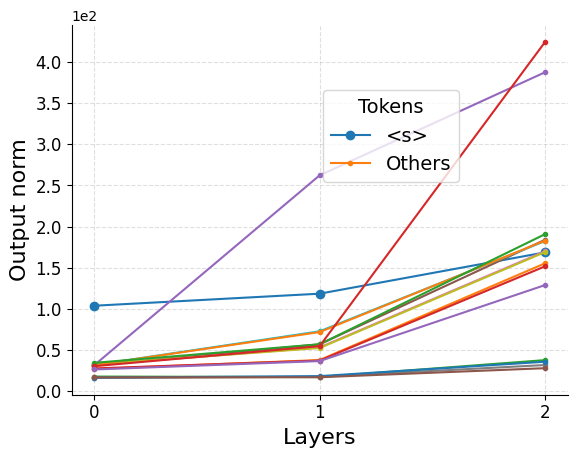

In [9]:
fig, ax = plt.subplots()
marker_list = ['o'] + ['.'] * 15
color_list = ['red'] + ['grey'] * 15
label_list = ['<s>'] + ['Others'] + [None] * 14

xticklabels = [0, 1, 2]
label = []

for i in range(16):
    ax.plot(layer_idx_list, norms[:, i], label=label_list[i], marker=marker_list[i],)


ax.grid(alpha=0.4, linestyle='--')
# change legend location to top left raised above plot
ax.legend(title="Tokens",  loc="center right", bbox_to_anchor=(0.8,0.7), title_fontsize=14, fontsize=14)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.set_xticks(layer_idx_list, xticklabels, fontsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_ylabel("Output norm", fontsize=16)
ax.set_xlabel("Layers", fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(os.path.join(fn, 'dormant_copy_L3_massive.pdf'), bbox_inches='tight', dpi=150)



## switch to bar plot

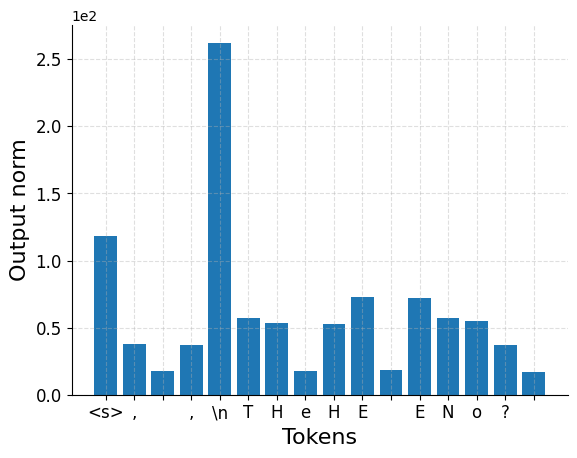

In [10]:
fig, ax = plt.subplots()
ax.bar(range(16), norms[1, :])

ax.grid(alpha=0.4, linestyle='--')
# change legend location to top left raised above plot
text[0] = '<s>'
text[4] = r'\n'
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.set_xticks(range(16), text, fontsize=12)
ax.tick_params(labelsize=12)
ax.set_ylabel("Output norm", fontsize=16)
ax.set_xlabel("Tokens", fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(os.path.join(fn, 'dormant_copy_L3_massive.pdf'), bbox_inches='tight', dpi=150)



In [13]:
all_norms = torch.zeros(3, 512, 256)
for layer_idx in range(3):
    all_norms[layer_idx, :] = outputs_list[layer_idx]['output'][:, :, :].norm(dim=-1).cpu().detach()
all_norms = all_norms.numpy()
norm_dict_list = [[(idx, []) for idx in ds.tok_range] for layer_idx in range(3)]
norm_dict_list = [dict(norm_dict) for norm_dict in norm_dict_list]
for layer_idx in range(3):
    for batch in range(x.shape[0]):
        for id in range(x.shape[1]):
            norm_dict_list[layer_idx][x[batch, id].item()].append(all_norms[layer_idx, batch, id].item())
means_list = [dict() for _ in range(3)]
sds_list = [dict() for _ in range(3)]

for layer_idx in range(3):
    for key, value in norm_dict_list[layer_idx].items():
        means_list[layer_idx][key], sds_list[layer_idx][key] = np.mean(value), np.std(value)

/data/tianyu_guo/miniconda3/envs/nanogpt/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/tianyu_guo/miniconda3/envs/nanogpt/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/data/tianyu_guo/miniconda3/envs/nanogpt/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/tianyu_guo/miniconda3/envs/nanogpt/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/data/tianyu_guo/miniconda3/envs/nanogpt/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


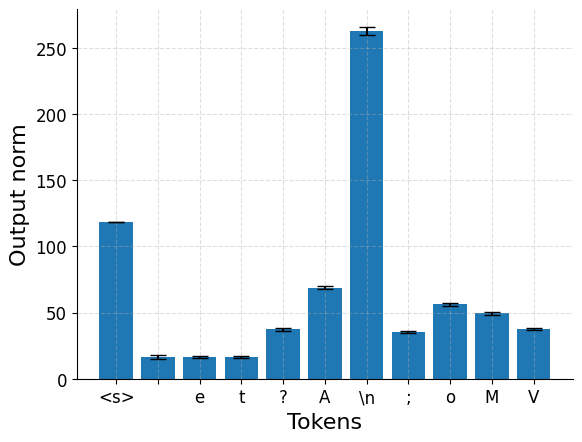

In [14]:
select_seq = [65, 1, 43, 58, 12, 13, 0, 11, 53, 25, 34]
text = ds.decode(select_seq)
text[0] = '<s>'
text[6] = r'\n'
select_norms = np.array([means_list[1][key] for key in select_seq])
select_stds = np.array([sds_list[1][key] for key in select_seq])

fig, ax = plt.subplots()
ax.bar(text, select_norms, yerr=select_stds, capsize=6)

ax.grid(alpha=0.4, linestyle='--')
# change legend location to top left raised above plot
# ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# ax.set_xticks(range(16), text, fontsize=12)
ax.tick_params(labelsize=12)
ax.set_ylabel("Output norm", fontsize=16)
ax.set_xlabel("Tokens", fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(os.path.join(fn, 'dormant_copy_L3_massive.pdf'), bbox_inches='tight', dpi=150)



## Try making boxenplot if time permits

In [135]:
select_seq = [65, 1, 43, 58, 47, 39, 0, 42, 50, 57, 47]
text = ds.decode(select_seq)
text[0] = '<s>'
text[6] = r'\n'
select_norms = [norm_dict_list[1][key] for key in select_seq]
sample_size = np.min([len(select_norms[idx]) for idx in range(len(select_seq))])
len(norm_dict_list[1][65])
ds.marginal.argsort()
fig, ax = plt.subplots()
flierprops = dict(marker='v', c='black', s=6,)

sns.boxenplot(attn_values, showfliers=True, flier_kws=flierprops, ax=ax)

ax.grid(alpha=0.4, linestyle='--')

# change legend location to top left raised above plot
ax.legend(loc='upper left', frameon=False, bbox_to_anchor=(-0.025, 1.04))

ax.set_xticks(list(range(10)), text_test, fontsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_ylabel("Norm", fontsize=16)
ax.set_xlabel("Value states", fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(os.path.join(fn, 'values.pdf'), bbox_inches='tight', dpi=150)
plt.savefig(os.path.join(fn, 'dormant_copy_L3_massive.pdf'), bbox_inches='tight', dpi=150)

## minor value states

In [18]:
all_norms = torch.zeros(3, 512, 256)
for layer_idx in range(3):
    all_norms[layer_idx, :] = outputs_list[layer_idx]['value_states'][:, 0, :, :].norm(dim=-1).cpu().detach()
all_norms = all_norms.numpy()
norm_dict_list = [[(idx, []) for idx in ds.tok_range] for layer_idx in range(3)]
norm_dict_list = [dict(norm_dict) for norm_dict in norm_dict_list]
for layer_idx in range(3):
    for batch in range(x.shape[0]):
        for id in range(x.shape[1]):
            norm_dict_list[layer_idx][x[batch, id].item()].append(all_norms[layer_idx, batch, id].item())
for layer_idx in range(3):
    for key, value in norm_dict_list[layer_idx].items():
        means_list[layer_idx][key], sds_list[layer_idx][key] = np.mean(value), np.std(value)

/data/tianyu_guo/miniconda3/envs/nanogpt/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/tianyu_guo/miniconda3/envs/nanogpt/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/data/tianyu_guo/miniconda3/envs/nanogpt/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/tianyu_guo/miniconda3/envs/nanogpt/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/data/tianyu_guo/miniconda3/envs/nanogpt/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


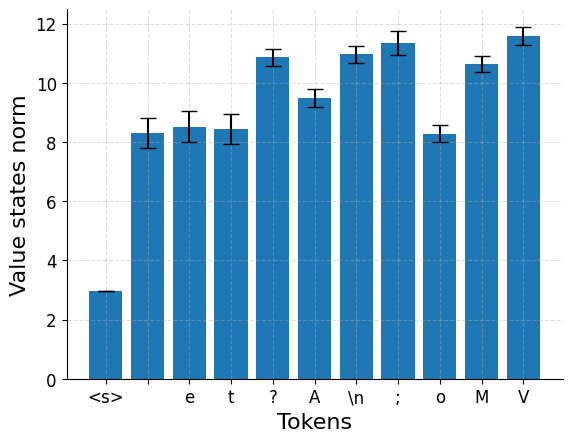

In [19]:
select_seq = [65, 1, 43, 58, 12, 13, 0, 11, 53, 25, 34]
text = ds.decode(select_seq)
text[0] = '<s>'
text[6] = r'\n'
select_norms = np.array([means_list[1][key] for key in select_seq])
select_stds = np.array([sds_list[1][key] for key in select_seq])

fig, ax = plt.subplots()
ax.bar(text, select_norms, yerr=select_stds, capsize=6)

ax.grid(alpha=0.4, linestyle='--')
# change legend location to top left raised above plot
# ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# ax.set_xticks(range(16), text, fontsize=12)
ax.tick_params(labelsize=12)
ax.set_ylabel("Value states norm", fontsize=16)
ax.set_xlabel("Tokens", fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(os.path.join(fn, 'dormant_copy_L3_value.pdf'), bbox_inches='tight', dpi=150)



## Dynamics

In [21]:
outputs_list_steps = {}
trigger_toks_steps = {}
attns_to_0_steps = {}
loss_steps = {}
icl_loss_steps = {}
markov_loss_steps = {}
steps_list = []
n_layers, n_heads, bos_num = 1, 1, 1
# f"/data/tianyu_guo/birth/gens/special/dormant_copy_2/model_L{n_layers}_H{n_heads}_bos{bos_num}_delim0/state_{train_steps}.pt"
dir_name = f"/data/tianyu_guo/birth/gens/pre_final/dormant_copy/model_L{n_layers}_H{n_heads}_bos{bos_num}_delim0"
model = model.cuda()
x = x.cuda()
y = y.cuda()
x_cpu = x.cpu()
i = 0
sub_steps = np.arange(100, 1020, 40).tolist()
with torch.no_grad():
    for fn in os.listdir(dir_name):
        if 'state' not in fn:
            continue
        step = int(fn.split('.')[0].split('_')[1])
        steps_list.append(step)
        state = torch.load(os.path.join(dir_name, fn), map_location="cuda")
        model.load_state_dict(state["model_state_dict"], strict=False, )
        trigger_toks, attns_to_0, markov_tok = get_triggers(ds, model, hook, cutoff=0.89)
        predicts, outputs_list = model.modified_forward_with_hook(x, hook)
        triggers_pos = ds.get_triggers_pos(x_cpu)
        trigger_pos = torch.from_numpy(triggers_pos).cuda()
        loss = F.cross_entropy(predicts.flatten(0, 1), y.flatten(0, 1))
        icl_loss = F.cross_entropy(predicts[triggers_pos, :], y[triggers_pos])
        markov_loss = F.cross_entropy(predicts[~triggers_pos, :], y[~triggers_pos])
        outputs_list = move_device(outputs_list)
        loss_steps[step] = loss
        icl_loss_steps[step] = icl_loss
        markov_loss_steps[step] = markov_loss
        outputs_list_steps[step] = outputs_list
        trigger_toks_steps[step] = trigger_toks
        attns_to_0_steps[step] = attns_to_0
        i += 1
        print(i)
steps_list.sort()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235


RuntimeError: [enforce fail at alloc_cpu.cpp:75] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 134217728 bytes. Error code 12 (Cannot allocate memory)

: 